In [1]:
from astropy.io import ascii
import pylab as plt
%matplotlib inline

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.interpolate import interp1d

import pystan
import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
output_folder='./'
prfsize=np.array([18.15,25.15,36.3])
#use Gaussian2DKernel to create prf (requires stddev rather than fwhm hence pfwhm/2.355)
from astropy.convolution import Gaussian2DKernel
pixsize=[6,8,10]
##---------fit using Gaussian beam-----------------------
prf250=Gaussian2DKernel(prfsize[0]/2.355,x_size=101,y_size=101)
prf250.normalize(mode='peak')
prf350=Gaussian2DKernel(prfsize[1]/2.355,x_size=101,y_size=101)
prf350.normalize(mode='peak')
prf500=Gaussian2DKernel(prfsize[2]/2.355,x_size=101,y_size=101)
prf500.normalize(mode='peak')
pind250=np.arange(0,101,1)*1.0/pixsize[0] #get 250 scale in terms of pixel scale of map
pind350=np.arange(0,101,1)*1.0/pixsize[1] #get 350 scale in terms of pixel scale of map
pind500=np.arange(0,101,1)*1.0/pixsize[2] #get 500 scale in terms of pixel scale of map

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [24]:
print np.vstack((pind250,pind250)).T.shape
print X.shape

(101, 2)
(50, 2)


In [3]:
import numpy as np
import GPy
from IPython.display import display


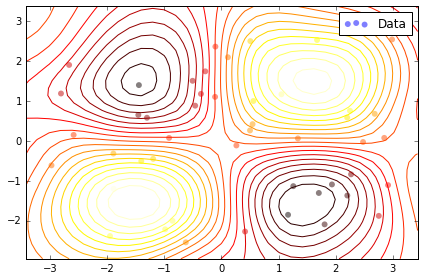

GP_regression.,value,constraints,priors
sum.Mat52.variance,0.431440450636,+ve,
sum.Mat52.lengthscale,"(2,)",+ve,
sum.white.variance,0.000646060584899,+ve,
Gaussian_noise.variance,0.000646060584899,+ve,


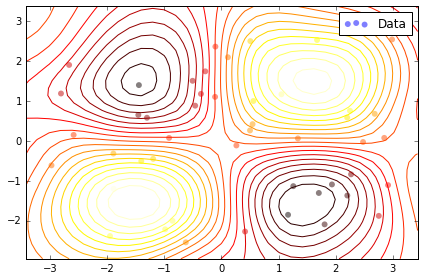

In [5]:
# sample inputs and outputs
X = np.random.uniform(-3.,3.,(50,2))
Y = np.sin(X[:,0:1]) * np.sin(X[:,1:2])+np.random.randn(50,1)*0.05

# define kernel
ker = GPy.kern.Matern52(2,ARD=True) + GPy.kern.White(2)

# create simple GP model
m = GPy.models.GPRegression(X,Y,ker)

# optimize and plot
m.optimize(messages=True,max_f_eval = 1000)
fig = m.plot()
display(GPy.plotting.show(fig))
display(m)

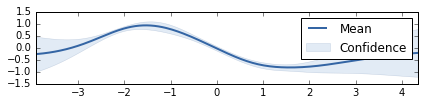

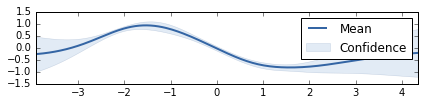

In [16]:
slices = [-1, 0, 1.5]
figure = GPy.plotting.plotting_library().figure(3, 1)
#for i, y in zip(range(3), slices):
i=1
y=slices[0]
canvas = m.plot(figure=figure, fixed_inputs=[(1,y)], row=(i+1), plot_data=False)
GPy.plotting.show(canvas)

In [42]:
prf_y=prf250.array.reshape(101**2,1)

X,Y=np.meshgrid(pind250,pind250)
prf_x=np.vstack((X.ravel(),Y.ravel())).T


In [41]:
print np.vstack((X.ravel(),Y.ravel())).T

[[  0.           0.        ]
 [  0.16666667   0.        ]
 [  0.33333333   0.        ]
 ..., 
 [ 16.33333333  16.66666667]
 [ 16.5         16.66666667]
 [ 16.66666667  16.66666667]]


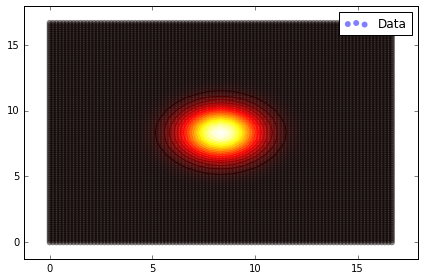

GP_regression.,value,constraints,priors
rbf.variance,0.00910810069394,+ve,
rbf.lengthscale,1.78191987823,+ve,
Gaussian_noise.variance,1.62823048844e-23,+ve,


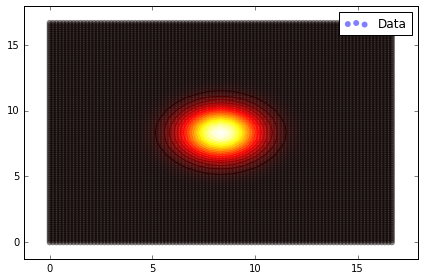

In [43]:
# define kernel
ker = GPy.kern.RBF(2,ARD=False)

# create simple GP model
m = GPy.models.GPRegression(prf_x,prf_y,ker)

# optimize and plot
m.optimize(messages=True,max_f_eval = 1000)
fig = m.plot()
display(GPy.plotting.show(fig))
display(m)


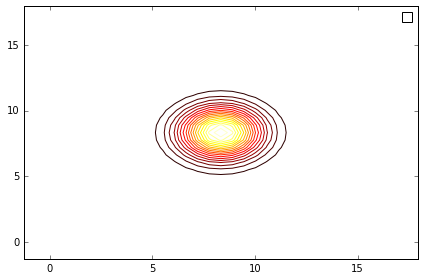

In [50]:
fig = m.plot(plot_data=False)


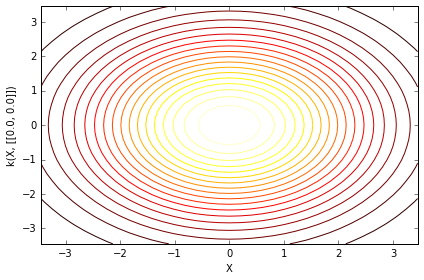

In [52]:
ker.plot()

In [67]:
m.predict(np.array([50.0/6,50.0/6]).reshape(1,2))


(array([[ 0.99995694]]), array([[  2.84433517e-10]]))

I can make this simpler by doing a radial profile rather than full 2D. Of course, this assumes symmetric PSF
TO do this I need:
1. Euclidean distance
2. Euclidean distance as an index

In [2]:
from astropy.io import ascii, fits
import pylab as plt
%matplotlib inline
from astropy import wcs


import numpy as np
import xidplus
from xidplus import moc_routines
import pickle

In [3]:
#Folder containing maps
imfolder=xidplus.__path__[0]+'/../test_files/'

pswfits=imfolder+'cosmos_itermap_lacey_07012015_simulated_observation_w_noise_PSW_hipe.fits.gz'#SPIRE 250 map
pmwfits=imfolder+'cosmos_itermap_lacey_07012015_simulated_observation_w_noise_PMW_hipe.fits.gz'#SPIRE 350 map
plwfits=imfolder+'cosmos_itermap_lacey_07012015_simulated_observation_w_noise_PLW_hipe.fits.gz'#SPIRE 500 map


#Folder containing prior input catalogue
catfolder=xidplus.__path__[0]+'/../test_files/'
#prior catalogue
prior_cat='lacey_07012015_MillGas.ALLVOLS_cat_PSW_COSMOS_test.fits'


#output folder
output_folder='./'

In [4]:
#-----250-------------
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist[1].header

im250=hdulist[1].data*1.0E3
nim250=hdulist[2].data*1.0E3
w_250 = wcs.WCS(hdulist[1].header)
pixsize250=3600.0*w_250.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----350-------------
hdulist = fits.open(pmwfits)
im350phdu=hdulist[0].header
im350hdu=hdulist[1].header

im350=hdulist[1].data*1.0E3
nim350=hdulist[2].data*1.0E3
w_350 = wcs.WCS(hdulist[1].header)
pixsize350=3600.0*w_350.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----500-------------
hdulist = fits.open(plwfits)
im500phdu=hdulist[0].header
im500hdu=hdulist[1].header
im500=hdulist[1].data*1.0E3
nim500=hdulist[2].data*1.0E3
w_500 = wcs.WCS(hdulist[1].header)
pixsize500=3600.0*w_500.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()

In [5]:
hdulist = fits.open(catfolder+prior_cat)
fcat=hdulist[1].data
hdulist.close()
inra=fcat['RA']
indec=fcat['DEC']

sgood=fcat['S100']>0.0001

inra=inra[sgood]
indec=indec[sgood]

In [6]:
#---prior250--------
prior250=xidplus.prior(im250,nim250,im250phdu,im250hdu)#Initialise with map, uncertianty map, wcs info and primary header
prior250.prior_cat(inra,indec,prior_cat)#Set input catalogue
prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Guassian pdf with mu and sigma)
#---prior350--------
prior350=xidplus.prior(im350,nim350,im350phdu,im350hdu)
prior350.prior_cat(inra,indec,prior_cat)
prior350.prior_bkg(-5.0,5)

#---prior500--------
prior500=xidplus.prior(im500,nim500,im500phdu,im500hdu)
prior500.prior_cat(inra,indec,prior_cat)
prior500.prior_bkg(-5.0,5)

In [7]:
#pixsize array (size of pixels in arcseconds)
pixsize=np.array([pixsize250,pixsize350,pixsize500])
#point response function for the three bands
prfsize=np.array([18.15,25.15,36.3])
#use Gaussian2DKernel to create prf (requires stddev rather than fwhm hence pfwhm/2.355)
from astropy.convolution import Gaussian2DKernel

##---------fit using Gaussian beam-----------------------
prf250=Gaussian2DKernel(prfsize[0]/2.355,x_size=101,y_size=101)
prf250.normalize(mode='peak')
prf350=Gaussian2DKernel(prfsize[1]/2.355,x_size=101,y_size=101)
prf350.normalize(mode='peak')
prf500=Gaussian2DKernel(prfsize[2]/2.355,x_size=101,y_size=101)
prf500.normalize(mode='peak')

pind250=np.arange(0,101,1)*1.0/pixsize[0] #get 250 scale in terms of pixel scale of map
pind350=np.arange(0,101,1)*1.0/pixsize[1] #get 350 scale in terms of pixel scale of map
pind500=np.arange(0,101,1)*1.0/pixsize[2] #get 500 scale in terms of pixel scale of map

prior250.set_prf(prf250.array,pind250,pind250)#requires psf as 2d grid, and x and y bins for grid (in pixel scale)
prior350.set_prf(prf350.array,pind350,pind350)
prior500.set_prf(prf500.array,pind500,pind500)

In [8]:
order=10
Tile=6977662
moc=moc_routines.get_fitting_region(order,Tile)
prior250.set_tile(moc)
prior350.set_tile(moc)
prior500.set_tile(moc)

In [9]:
#prior250.get_pointing_matrix()
prior350.get_pointing_matrix()
prior500.get_pointing_matrix()


/Users/pdh21/HELP/XID_plus/xidplus/prior.py:191: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dx = -np.rint(self.sx[s]).astype(long) + self.pindx[(paxis1 - 1.) / 2] + self.sx_pix
/Users/pdh21/HELP/XID_plus/xidplus/prior.py:193: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dy = -np.rint(self.sy[s]).astype(long) + self.pindy[(paxis2 - 1.) / 2] + self.sy_pix


In [10]:
prior250.get_pointing_matrix_unknown_psf()

/Users/pdh21/HELP/XID_plus/xidplus/prior.py:262: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  f = interpolate.interp1d(self.pindx[0:(paxis1 + 1.) / 2],np.arange((paxis1 + 1.) / 2.),kind='nearest')


In [11]:
prior250.nsrc

640

In [14]:
import pylab as plt
%matplotlib inline

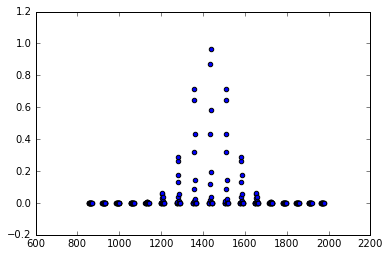

In [15]:
ind=amat_col==34

plt.scatter(amat_row[ind],amat_data[ind])

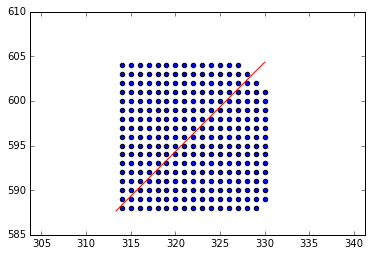

In [16]:
test=np.zeros((np.max(prior250.sx_pix),np.max(prior250.sy_pix)))
plt.scatter(prior250.sx_pix[amat_row[ind]],prior250.sy_pix[amat_row[ind]])
plt.axes().set_aspect('equal', 'datalim')
plt.plot(np.array(prior250.sx[34]+prior250.pindx-prior250.pindx[50]),np.array(prior250.sy[34]+prior250.pindy-prior250.pindy[50]),'r')
test[prior250.sx_pix[amat_row[ind]],prior250.sy_pix[amat_row[ind]]]=amat_data[ind]

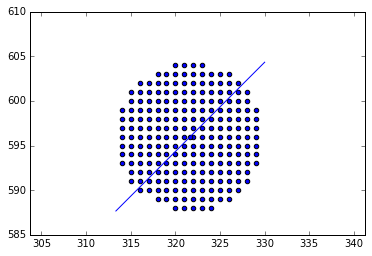

In [17]:
ind=prior250.amat_col==34
test2=np.zeros((np.max(prior250.sx_pix),np.max(prior250.sy_pix)))

plt.scatter(prior250.sx_pix[prior250.amat_row[ind]],prior250.sy_pix[prior250.amat_row[ind]])
plt.axes().set_aspect('equal', 'datalim')
plt.scatter(prior250.sx[34],prior250.sy[34])
plt.plot(np.array(prior250.sx[34]+prior250.pindx-prior250.pindx[50]),np.array(prior250.sy[34]+prior250.pindy-prior250.pindy[50]),)
test2[prior250.sx_pix[prior250.amat_row[ind]],prior250.sy_pix[prior250.amat_row[ind]]]=prior250.amat_data[ind]

(300, 350)

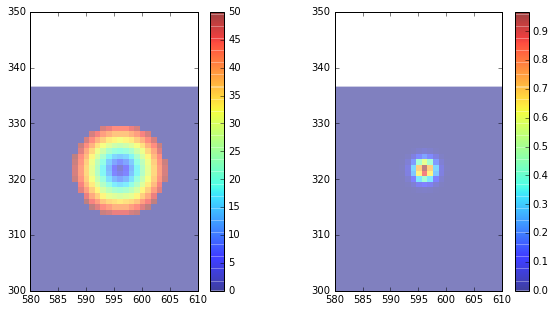

In [18]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(test2,alpha=0.5, interpolation='nearest')
plt.colorbar()
plt.xlim(580,610)
plt.ylim(300,350)
plt.subplot(1,2,2)
plt.imshow(test,alpha=0.5, interpolation='nearest')
plt.colorbar()
plt.xlim(580,610)
plt.ylim(300,350)



In [12]:
prior250.upper_lim_map()
prior350.upper_lim_map()
prior500.upper_lim_map()

In [13]:
from xidplus.stan_fit import SPIRE
fit=SPIRE.all_bands_PSF(prior250,prior350,prior500,51,np.arange(51),iter=1000)

/Users/pdh21/HELP/XID_plus/notebooks/XID+SPIRE_PSF.pkl found. Reusing


In [14]:
posterior=xidplus.posterior_stan(fit,[prior250,prior350,prior500])


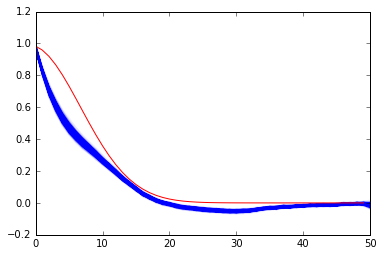

In [15]:
for i in range(0,2000):
    plt.plot(posterior.stan_fit[:,:,-52:-1].reshape(2000,51)[i,:],'b',alpha=0.02,linestyle='-')
plt.plot()
plt.plot(prior250.prf[51:,51],'r')

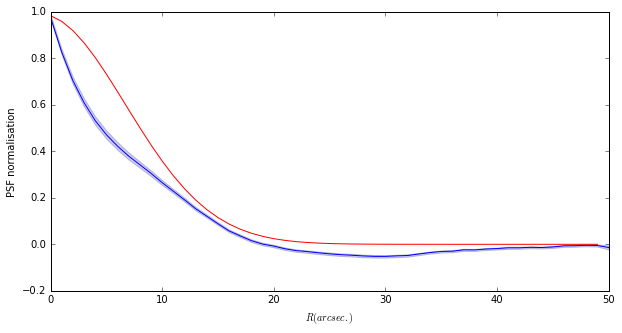

In [16]:
plt.figure(figsize=(10,5))
psf_fit=np.percentile(posterior.stan_fit[:,:,-52:-1].reshape(2000,51),[16.0,50.0,84.0],axis=0)
plt.plot(psf_fit[1,:],'b')
plt.fill_between(np.arange(0,51),psf_fit[0,:],psf_fit[2,:],alpha=0.2)
plt.plot(prior250.prf[51:,51],'r')
plt.xlabel(r'$R (arcsec.)$')
plt.ylabel(r'PSF normalisation')

In [47]:
Sigma=np.empty((51,51))
for i in range(0,51): 
    for j in range(0,51):
        Sigma[i,j] =np.exp(-0.01 * np.power(np.arange(51)[i] - np.arange(51)[j],2))
        if i==j:
            Sigma[i,j]=Sigma[i,j]+0.00001


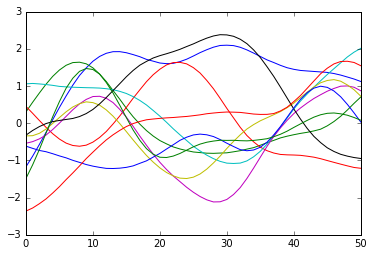

In [48]:
mu=np.zeros(51)

for i in range(0,10):
    plt.plot(np.random.multivariate_normal(mu, Sigma,10)[i])

(array([ 531.,  486.,  357.,  244.,  185.,   95.,   63.,   27.,    9.,    3.]),
 array([ 0.01121685,  1.00528446,  1.99935207,  2.99341967,  3.98748728,
         4.98155489,  5.9756225 ,  6.9696901 ,  7.96375771,  8.95782532,
         9.95189293]),
 <a list of 10 Patch objects>)

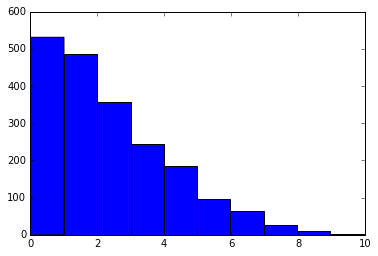

In [18]:
plt.hist(posterior.stan_fit[:,:,5].reshape(-1))



In [19]:
prior250.nsrc

282

Why is the PSF not correct and why does it change with number of sources?